# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

** Define functions:**

In [5]:
import numpy as np

In [6]:
# Gini evaluation:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)  #Porcentaje al cuadrado de la categoria 1 + el porcentaje al cuadrado de la categoria 0
    
    #GINI: que tan disímiles son las dos clases.

In [7]:
# Calculation of Gini impurity
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    # LA x solo se usa para partir, porque luego se mira que tan diferentes son pero respecto a y.
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    #Calcular el numero en cada vector y_l y y_r
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    # 
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    # ganancia en los gini de cada lado, en porcentaje cuantas de cada lado.
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    # Si esta balanceado, da 0. Si todo está a un lado tiende a 1. Lo que se quiere es separar los ceros para un lado
    # y los unos para el otro, es decir, un gini mayor, que se acerque a 1.
    
    return gini_impurity_

In [8]:
# Evaluate the best split:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    # se almacenan el mejor split
    best_split = [0, 0, 0]  # j, split, gain: indice, particion y ganancia.
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
           # Este guarda el split solo si es mejor que el que estaba almacenado.             
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [9]:
# Function that create the tree:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction: para que no dé infinito, se suma 1 al numerador y 2 al denominador
    
    #Guarda l ainfomración del nodo:
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria: antes de partir, evalua:
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Si no se cumple, entonces se parte:
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    
    # Clave: para cada partición, se vuelve a ejecutar toda la función.
    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [10]:
# create the tree
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [11]:
pd.DataFrame(X_train.columns)

,0
0,Year
1,Mileage
2,M_Camry
3,M_Camry4dr
4,M_CamryBase
5,M_CamryL
6,M_CamryLE
7,M_CamrySE
8,M_CamryXLE


In [12]:
# See the tree
tree

{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': [0, 2014.0],
  'n_samples': 5606,
  'gain': 0.03317687167496233,
  'sl': {'y_pred': 0,
   'y_prob': 0.36828644501278773,
   'level': 2,
   'split': [0, 2012.0],
   'n_samples': 389,
   'gain': 0.05908490521197157,
   'sl': {'y_pred': 0,
    'y_prob': 0.08,
    'level': 3,
    'split': -1,
    'n_samples': 98,
    'gain': -1},
   'sr': {'y_pred': 0,
    'y_prob': 0.46757679180887374,
    'level': 3,
    'split': -1,
    'n_samples': 291,
    'gain': -1}},
  'sr': {'y_pred': 1,
   'y_prob': 0.8743054224947308,
   'level': 2,
   'split': [0, 2015.0],
   'n_samples': 5217,
   'gain': 0.014933378976312917,
   'sl': {'y_pred': 1,
    'y_prob': 0.7348484848484849,
    'level': 3,
    'split': -1,
    'n_samples': 1450,
    'gain': -1},
   'sr': {'y_pred': 1,
    'y_prob': 0.92

**Predictions:**

In [13]:
def tree_predict(X, tree, proba=False):
  # Se recorre el arbol para hallar en donde cae la predicción.  
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
# Falta corregir en el caso que haya algún nodo vacío.
        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted  

In [14]:
y_pred = pd.DataFrame(tree_predict(X_test, tree))

**Measuring the accuracy:**

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8610599078341014

# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

** Create the samples:**

In [16]:
# Number of data selected randomly from dataset
n_estimators = 10
# Number of trees to create
n_samples = 300 

# set a seed for reproducibility
np.random.seed(123)

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_estimators, replace=True) for _ in range(n_samples)]

In [17]:
# 10 Decision Trees Manually:

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(n_estimators):
    trees[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [18]:
# Predict 
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

In [19]:
y_pred_df.sample(10)

,0,1,2,3,4,5,6,7,8,9
5378,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
407715,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
46747,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
76818,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
138296,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
135223,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
151728,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
111119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112193,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
362372,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


**Accuracy:**

In [20]:
# Calculate the aprox probability:
acc=[0,0]
for i in np.arange(0.01,1,0.01):
    y_pred2 = (y_pred_df.sum(axis=1) >= (n_samples*i)).astype(np.int)
    ac = accuracy_score(y_pred2, y_test)
    if ac > acc[0]:
        acc = [ac,i]
print('Threshold: ',acc[1],'\nAccuracy: ',acc[0])

Threshold:  0.02 
Accuracy:  0.8658986175115208


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

**Tree modified with `max_features`**

In [21]:
np.int(np.log(len(X.columns)))

2

In [22]:
# Function that create the tree, with the parameter max_features
def tree_grow2(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=None):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    if isinstance(max_features,str):      
        # If “sqrt”, then max_features=sqrt(n_features) (same as “auto”).
        if max_features == 'sqrt':
            max_feat = np.int(np.sqrt(len(X.columns)))
            feat=np.random.choice(a=len(X.columns), size=max_feat, replace=False)
            feat.sort()
            X = X.iloc[:,feat]
        # If “log”, then max_features=log2(n_features).
        elif max_features == 'log':
            max_feat = np.int(np.log(len(X.columns)))
            feat=np.random.choice(a=len(X.columns), size=max_feat, replace=False)
            feat.sort()
            X = X.iloc[:,feat]
    else:
        # Handlig possible errors:
        if max_features > len(X.columns):
            return print("Error, max_features can't be grather than X size\nX size: ",len(X.columns))

        # Calculate the X with the max_features
        # If None, then max_features = n_features, X = X
        if max_features != None:
            # Select max_features random features:
            max_feat = max_features
            feat=np.random.choice(a=len(X.columns), size=max_feat, replace=False)
            feat.sort()
            X = X.iloc[:,feat]

        
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction: para que no dé infinito, se suma 1 al numerador y 2 al denominador
    
    #Guarda la infomración del nodo:
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria: antes de partir, evalua:
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    # Si no se cumple, entonces se parte:
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain
    
    # Clave: para cada partición, se vuelve a ejecutar toda la función.
    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [23]:
# Calculate the aprox probability:
cols=['max_features','Accuracy']
acc2=pd.DataFrame(columns=cols,data=[])
mf = range(0,X.shape[1]+1)

for i in mf:
    tree = tree_grow2(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10, max_features=i)
    y_pred = pd.DataFrame(tree_predict(X_test, tree))
    acc2.loc[i] = [i,accuracy_score(y_test, y_pred)]

Text(0,0.5,'Accuracy')

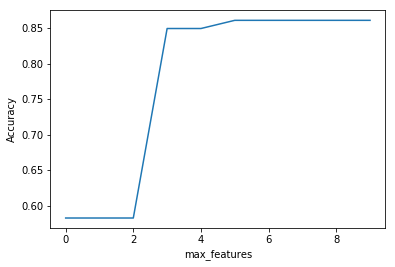

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# plot max_features (x-axis) versus Accuracy (y-axis)
plt.plot(acc2.max_features, acc2.Accuracy)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)` : Random Forest Manual

Evaluate the accuracy on the testing set

In [25]:
# Number of data selected randomly from dataset
n_estimators = 10
# Number of trees to create
n_samples = 300 

# set a seed for reproducibility
np.random.seed(123)

# create bootstrap samples (will be used to select rows from the DataFrame)
samples = [np.random.choice(a=n_samples, size=n_estimators, replace=True) for _ in range(n_samples)]

In [26]:
# 10 Decision Trees Manually:

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees2 = {}
for i in range(n_estimators):
    trees2[i] = tree_grow2(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, 
                          min_gain=0.001, max_depth=3, num_pct=10, max_features='log')

In [27]:
# Predict 
y_pred_df2 = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    y_pred_df2.iloc[:, i] = tree_predict(X_test, trees2[i])

In [28]:
y_pred_df2.sample(10)

,0,1,2,3,4,5,6,7,8,9
196856,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
212388,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
44284,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
217786,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
492004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
297479,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
441559,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
373842,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
375854,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
138719,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


**Accuracy:**

In [29]:
# Calculate the aprox probability:
acc=[0,0]
for i in np.arange(0.01,1,0.01):
    y_pred3 = (y_pred_df2.sum(axis=1) >= (n_samples*i)).astype(np.int)
    ac = accuracy_score(y_pred2, y_test)
    if ac > acc[0]:
        acc = [ac,i]
print('Threshold: ',acc[1],'\nAccuracy: ',acc[0])

Threshold:  0.01 
Accuracy:  0.41751152073732717


# Exercise 11.5

Using sklearn, train a RandomForestClassifier: Use 10 trees

Evaluate the accuracy on the testing set

In [30]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10)
clf.fit(X_train,y_train)
y_pred3 = clf.predict(X_test)
accuracy_score(y_pred3, y_test)

0.8375576036866359

# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

**Tunning the `max_depth`:**

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
# list of values to try for max_depth:
maxdepth_range = range(1,20)
estimator = 10


# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for md in maxdepth_range:
    clf = RandomForestClassifier(n_estimators=estimator,max_depth=md, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

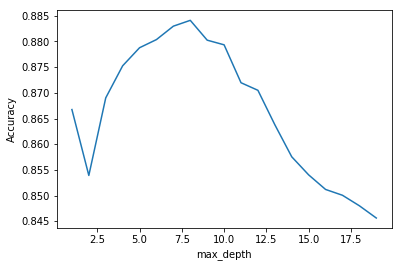

In [33]:
# plot max_depth (x-axis) versus Accuracy (y-axis)
plt.plot(maxdepth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

**Tunning the `max_features`:**

In [34]:
# list of values to try for max_depth:
maxfeatures_range = range(1,X.shape[1])
estimator = 10


# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for mf in maxfeatures_range:
    clf = RandomForestClassifier(n_estimators=estimator, max_depth=8, max_features=mf, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

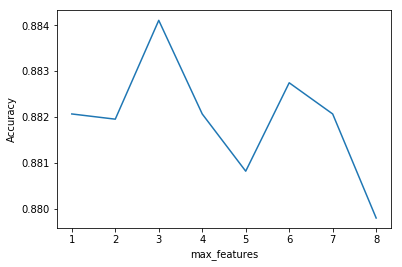

In [35]:
# plot max_depth (x-axis) versus Accuracy (y-axis)
plt.plot(maxfeatures_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

**Tunning the `n_estimators`:**

In [36]:
# list of values to try for max_depth:
estimators_range = range(10,300,10)

# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimators_range:
    clf = RandomForestClassifier(n_estimators=estimator, max_depth=8, max_features=3, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

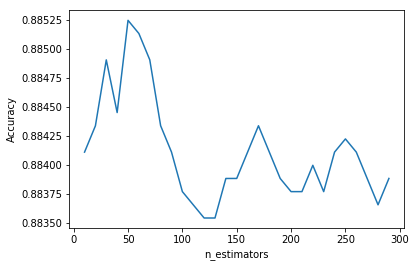

In [37]:
# plot max_depth (x-axis) versus Accuracy (y-axis)
plt.plot(estimators_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

**Computing Random Forest with the best parameters:**

In [38]:
clf = RandomForestClassifier(n_estimators=50, max_depth=8, max_features=3, random_state=1, n_jobs=-1)
cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy').mean()

0.8852434957452285